In [ ]:
# !tar -xvzf features.tar.gz

In [ ]:
# !pip install ftfy regex tqdm
# !pip install git+https://github.com/openai/CLIP.git

In [1]:
import os
for file in os.listdir("./data/context"):
    if not file.endswith(".jpg"):
        print(file)
        break

images


In [2]:
len(os.listdir("./data/context"))

4

In [1]:
import os
import cv2
import shutil
import random

import json
import numpy as np
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchsummary import summary
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from tqdm import tqdm
from copy import deepcopy
import sklearn.metrics
from sklearn.metrics import classification_report

import clip

/scratch/miniconda3/envs/fine_grained/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings("ignore")

## dataset class

#### bottle dataset

In [3]:
def make_disjoint_data(data_json_path: str, num_classes, k_split=None):
    json_obj = json.load(open(data_json_path, "r"))

    if k_split is None:
        k_split = num_classes//2

    shuffled_labels = [i+1 for i in range(num_classes)] # inc, exc
    random.shuffle(shuffled_labels)
    train_labels = shuffled_labels[:k_split]    # selected for training
    test_labels = shuffled_labels[k_split:]
    
    split_dict = {"train":{}, "test":{}}
    train_mapping_dict = {str(i+1):str(train_labels[i]) for i in range(len(train_labels))}
    test_mapping_dict = {str(i+1):str(test_labels[i]) for i in range(len(test_labels))}

    label_to_pseudo_train = {train_labels[i]:str(i+1) for i in range(len(train_labels))}
    label_to_pseudo_test = {test_labels[i]:str(i+1) for i in range(len(test_labels))}
    print(label_to_pseudo_train)
    print(label_to_pseudo_test)

    for split_type in json_obj:     # train/test
        if split_type not in ["train", "test"]:
            continue
        for name, label in json_obj[split_type].items():
            if int(label) in label_to_pseudo_train:
                pseudo_label = label_to_pseudo_train[int(label)]
                split_dict["train"][name] = str(pseudo_label)
            else:
                pseudo_label = label_to_pseudo_test[int(label)]
                split_dict["test"][name] = str(pseudo_label)

    os.makedirs(os.path.join(f"{os.path.dirname(data_json_path)}", "disjoint"), exist_ok=True)
    save_loc = os.path.join(f"{os.path.dirname(data_json_path)}", "disjoint", os.path.basename(data_json_path))

    labels_tr = set(list(label_to_pseudo_train.keys()))
    labels_te = set(list(label_to_pseudo_test.keys()))
    print(labels_tr)
    print(labels_te)
    print("##", labels_tr.intersection(labels_te))

    split_dict["train_classes"] = list(label_to_pseudo_train.values())
    split_dict["val_classes"] = list(label_to_pseudo_test.values())
    
    split_dict["classes"] = shuffled_labels
    split_dict["mapping_dict"] = {}
    split_dict["mapping_dict"]['train'] = train_mapping_dict
    split_dict["mapping_dict"]['test'] = test_mapping_dict
    with open(save_loc,"w") as f:
        json.dump(split_dict,f)

In [4]:
for base_path,num_classes in [('data/bottle/', 20), ('data/context',28)]:
    for i in range(3):
        path = base_path +'/split_'+ str(i) +'.json'
        make_disjoint_data(data_json_path=path,
                                num_classes=num_classes)

{8: '1', 5: '2', 16: '3', 6: '4', 15: '5', 7: '6', 17: '7', 12: '8', 9: '9', 1: '10'}
{4: '1', 14: '2', 20: '3', 3: '4', 19: '5', 10: '6', 18: '7', 13: '8', 2: '9', 11: '10'}
{1, 5, 6, 7, 8, 9, 12, 15, 16, 17}
{2, 3, 4, 10, 11, 13, 14, 18, 19, 20}
## set()
{19: '1', 7: '2', 4: '3', 5: '4', 9: '5', 15: '6', 14: '7', 16: '8', 8: '9', 20: '10'}
{13: '1', 17: '2', 12: '3', 2: '4', 6: '5', 11: '6', 3: '7', 10: '8', 18: '9', 1: '10'}
{4, 5, 7, 8, 9, 14, 15, 16, 19, 20}
{1, 2, 3, 6, 10, 11, 12, 13, 17, 18}
## set()
{5: '1', 1: '2', 2: '3', 15: '4', 10: '5', 11: '6', 7: '7', 6: '8', 18: '9', 8: '10'}
{4: '1', 14: '2', 20: '3', 17: '4', 12: '5', 9: '6', 19: '7', 13: '8', 16: '9', 3: '10'}
{1, 2, 5, 6, 7, 8, 10, 11, 15, 18}
{3, 4, 9, 12, 13, 14, 16, 17, 19, 20}
## set()
{11: '1', 25: '2', 5: '3', 18: '4', 19: '5', 13: '6', 27: '7', 21: '8', 23: '9', 15: '10', 26: '11', 6: '12', 2: '13', 20: '14'}
{28: '1', 24: '2', 8: '3', 4: '4', 14: '5', 17: '6', 16: '7', 22: '8', 12: '9', 1: '10', 10: '11', 9

[INFO]: split: 0 | path: ./data/context/
[INFO]: mode: train | split_file: ./data/context//split_0.json
dict_keys(['test', 'train'])
Total num classes: 28


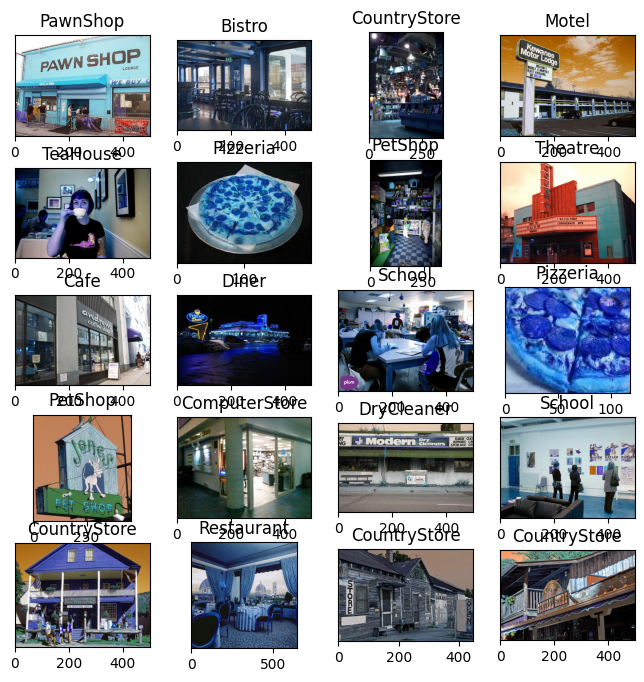


class distribution with data size of:  16179


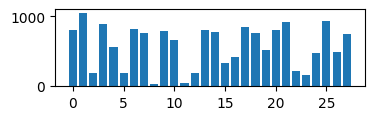

----------------------------------------------------
[INFO]: split: 0 | path: ./data/context
[INFO]: mode: test | split_file: ./data/context/split_0.json
dict_keys(['test', 'train'])
Total num classes: 28


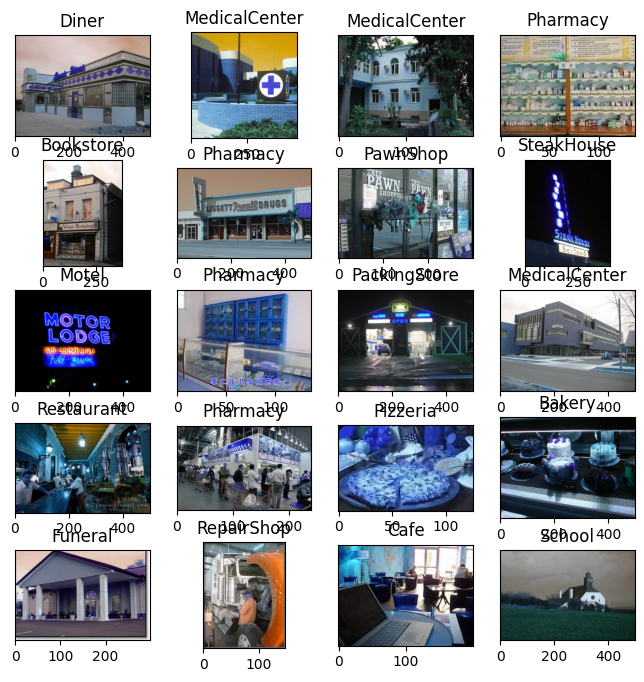


class distribution with data size of:  8076


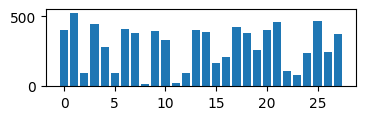

----------------------------------------------------


In [5]:
class CommonDataset(Dataset):
  def __init__(self, data_path="./data", split=0, mode="train",
               verbose=1, transform=None, tokenize=False,
               disjoint=False):
    
    self.split = split
    self.mode = mode
    self.data_path = data_path
    self.disjoint = disjoint
    self.label_path = ""
    if self.disjoint:
      self.label_path = "disjoint"

    print(f"[INFO]: split: {split} | path: {data_path}")
    print(f"[INFO]: mode: {mode} | split_file: {self.data_path + self.label_path +'/split_'+ str(self.split) +'.json'}")

    with open(self.data_path + f"/{self.label_path}" +'/split_'+ str(self.split) +'.json','r') as fp:
        self.gt_annotations = json.load(fp)
    print(self.gt_annotations.keys())
  
    with open(self.data_path + '/classes.json','r') as fp:
        self.classes_labels = json.load(fp)

    if self.mode == "train":
      self.transform = transforms.Compose([
          transforms.Resize((256, 256)),
          transforms.RandomRotation(degrees=15),
          transforms.ColorJitter(),
          transforms.RandomHorizontalFlip(),
          transforms.RandomCrop(224),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
      ])
    else:
      self.transform = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
      ])

    if transform is not None:
      self.transform = transform

    self.image_list = list(self.gt_annotations[self.mode].keys())
    self.num_classes = len(Counter(self.gt_annotations[self.mode].values()))
    if not self.disjoint:
      self.gt_annotations['train_classes'] = None
      self.gt_annotations['val_classes'] = None
      self.gt_annotations['mapping_dict'] = None
      # self.gt_annotations['train_classes'] = [str(i+1) for i in range(self.num_classes)]
      # self.gt_annotations['val_classes'] = [str(i+1) for i in range(self.num_classes)]
      # self.gt_annotations['mapping_dict'] = {
      #   "train" : {str(i+1):str(i+1) for i in range(self.num_classes)},
      #   "test" : {str(i+1):str(i+1) for i in range(self.num_classes)}
      # }
    print(f"Total num classes: {self.num_classes}")
    if verbose:
      self.visalize()
    self.tokenize=tokenize
      

  def visalize(self, w=50, h=50, columns=4, rows=5):
    w = 20
    h = 20
  
    fig = plt.figure(figsize=(8, 8))
    for i in range(1, columns*rows +1):
        idx = np.random.randint(1, len(self.image_list)-1)
        img = cv2.imread(os.path.join(self.data_path, self.image_list[idx]))
        fig.add_subplot(rows, columns, i)
        if self.disjoint:
          plt.title(self.classes_labels[self.gt_annotations['mapping_dict'][self.mode][self.gt_annotations[self.mode][self.image_list[idx]]]])
        else:
          plt.title(self.classes_labels[self.gt_annotations[self.mode][self.image_list[idx]]])
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.imshow(img)
    
    plt.show()
    data_dist = Counter(self.gt_annotations[self.mode].values())
    print("\nclass distribution with data size of: ", sum(data_dist.values()))
    plt.figure(figsize=(4, 1))
    plt.bar(range(len(data_dist)), list(data_dist.values()), align='center')
    plt.show()
    print("----------------------------------------------------")
    
  def __len__(self):
    return len(self.gt_annotations[self.mode])

  def __getitem__(self, idx):
    image_name = self.image_list[idx]
    img = Image.open(os.path.join(self.data_path, image_name)).convert('RGB')
    # print(os.path.join(self.data_path, image_name))
    img_class = self.gt_annotations[self.mode][image_name]
    label = np.zeros(self.num_classes)
    label[int(img_class) - 1] = 1
    label = torch.from_numpy(label)
    label = label.type(torch.FloatTensor)
    label_name = self.classes_labels[img_class]

    if self.transform:
      img = self.transform(img)
    
    if self.tokenize:
      label_name = clip.tokenize(label_name)
    return img, label, label_name

dataset = CommonDataset(data_path="./data/context/", mode="train", split=0, disjoint=False)
dataset = CommonDataset(data_path="./data/context", mode="test", split=0, disjoint=False)

## helper functions

In [6]:
def get_dataloaders(names=['bottle'], verbose=1,
                    train_batch_size=128, val_batch_size=16,
                    config_dict={
                        "bottle":{"path":"./data/bottle/", "split":0},
                        "activity":{"path":"./data/activity", "split":0}, 
                        "context":{"path":"./data/context","split":0}},
                    transform=None, tokenize=False, disjoint=False
                    ):
                    
    output_dict = {}

    for d_type in names:

        data_path = config_dict[d_type]['path']
        train_dataset = None
        val_dataset = None
        
        if d_type == "bottle":
            train_dataset = CommonDataset(data_path, mode='train',
                                          split=config_dict[d_type]['split'],
                                          verbose=verbose, transform=transform,
                                          tokenize=tokenize,disjoint=disjoint)
                                          
            val_dataset = CommonDataset(data_path, mode='test',
                                        split=config_dict[d_type]['split'],
                                        verbose=verbose, transform=transform,
                                        tokenize=tokenize,disjoint=disjoint)
        elif d_type == "activity":
            pass

        else:
            train_dataset = CommonDataset(data_path, mode='train',
                                          split=config_dict[d_type]['split'],
                                          verbose=verbose, transform=transform,
                                          tokenize=tokenize,disjoint=disjoint)
                                          
            val_dataset = CommonDataset(data_path, mode='test',
                                        split=config_dict[d_type]['split'],
                                        verbose=verbose, transform=transform,
                                        tokenize=tokenize,disjoint=disjoint)

        if train_dataset is None or val_dataset is None:
            output_dict[d_type] = {"train":None, "test":None, "num_classes":None}
            
        else:
            train_dataloader = DataLoader(
                    dataset=train_dataset, batch_size=train_batch_size, shuffle=True)
            val_dataloader = DataLoader(
                    dataset=val_dataset, batch_size=val_batch_size, shuffle=True)

            output_dict[d_type] = {"train":train_dataloader, "test":val_dataloader,
                                "num_classes":train_dataset.num_classes, "data_path":data_path,
                                "train_classes":train_dataset.gt_annotations['train_classes'],
                                "map_dict":train_dataset.gt_annotations['mapping_dict'],
                                "split":config_dict[d_type]['split']}

    return output_dict

In [7]:
def precision_recall_curve(y_true, pred_scores, thresholds, num_classes=20):
    precisions = []
    recalls = []

    for threshold in thresholds:
        y_pred = ["positive" if score >= threshold else "negative" for score in pred_scores]

        precision = sklearn.metrics.precision_score(y_true=y_true, y_pred=y_pred, pos_label="positive")
        recall = sklearn.metrics.recall_score(y_true=y_true, y_pred=y_pred, pos_label="positive")
        
        precisions.append(precision)
        recalls.append(recall)

    return precisions, recalls

In [8]:
def get_performance(model, dataloader, device='cuda',num_classes=20, double_headed_encoder=False, label_mapping=None):
  label_list = None
  pred_list = None
  pred_probab = None

  if label_mapping is None:
    label_mapping = {str(i+1):str(i+1) for i in range(num_classes)}
  else:
    label_mapping = label_mapping['test']

  print(f"FOR {num_classes}")
  with torch.no_grad():
    loop = tqdm(dataloader, total = len(dataloader), leave = True)
    for (imgs, labels, label_name) in loop:
        imgs = imgs.to(device)
        labels = labels.to(device)
        label_name = label_name.to(device)

        if not double_headed_encoder:
          outputs = model(imgs)
        else:
          # for CLIP
          outputs = model(imgs, label_name)

        # print(outputs)
        # print(outputs.shape)
        outputs = outputs.type(torch.float32)
        
        if labels.ndim > 1:
          labels = torch.max(labels, 1)[1]

        if label_list is None:
          label_list = labels.detach().cpu().numpy()
        else:
          label_list = np.concatenate([label_list,
                                        labels.detach().cpu().numpy()])
        
        softmaxed_outputs = F.softmax(outputs.detach().cpu()).numpy()
        if pred_list is None:
          pred_list = softmaxed_outputs.argmax(axis=1)
          pred_probab = softmaxed_outputs
        else:
          pred_list = np.concatenate([pred_list,
                                        softmaxed_outputs.argmax(axis=1)])
          pred_probab = np.concatenate([pred_probab,
                                        softmaxed_outputs])


  print("\n\n")
  report = classification_report(label_list, pred_list)
  print(report)
  # mAP

  thresholds = np.arange(start=0.2, stop=0.9, step=0.05)

  map_dict = {}
  for cls in range(num_classes):
    pred_scores = pred_probab[:, cls]
    
    y_true = []
    for y in label_list:
        if y == cls:
            y_true.append("positive")
        else:
            y_true.append("negative")

    precisions, recalls = precision_recall_curve(y_true=y_true, 
                                              pred_scores=pred_scores,
                                              thresholds=thresholds,
                                              num_classes=num_classes)                      
    precisions.append(1)
    recalls.append(0)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    AP = np.sum((recalls[:-1] - recalls[1:]) * precisions[:-1])
    map_dict[int(label_mapping[str(cls+1)])] = AP
  for m in map_dict:
    print(f"{m} -> {map_dict[m]:.5f}")
  return map_dict

In [9]:
def evaluate(
            final_model,
            d_type,
            transform,
            device='cpu',
            config_dict={"bottle":{"path":"data/bottle","split":0, "cls":20},
                         "context":{"path":"data/context","split":0, "cls":28}},
            disjoint=False
            ):
    
    score_dict = {}
    
    overall_map=0
    print(f"-------------EVALUATING FOR {d_type}-------------")
    for split in range(0,3):
        config_dict[d_type]['split'] = split

        dataloaders = get_dataloaders([d_type], train_batch_size=128, val_batch_size=32,
                                    config_dict=config_dict, verbose=0,
                                    transform=transform,tokenize=True,disjoint=disjoint)
        
        print(dataloaders)
        map_dict = get_performance(final_model,
                        dataloaders[d_type]["test"],
                        num_classes=dataloaders[d_type]['num_classes'],
                        device=device,
                        double_headed_encoder=False)
        
        score_dict[f"split:{split}"] = np.array(list(map_dict.values())).mean()
        print(f"mAP for split{split}:", np.array(list(map_dict.values())).mean())
        overall_map += np.array(list(map_dict.values())).mean()

    print(f"overall mAP:", overall_map/3)
    score_dict['overall_mAP'] = overall_map/3

    return score_dict

In [10]:
class ConditionedStopping:
    def __init__(self, tolerance=5, min_delta=0.5):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.previous_value = 0.0
        self.counter = 0
        self.stop_training = False

    def __call__(self, current_value):
        if abs(current_value-self.previous_value) < self.min_delta:
            self.counter += 1
            if self.counter > self.tolerance:
                self.stop_training = True
                
        self.previous_value = current_value

In [11]:
def get_zero_shot_evaluation_model(trained_base_model, data_path, num_classes,
                                   dataloader, device='cpu', 
                                   train_classes=None, mapping_dict=None):
    # val-datalloader : disjoint test
    # image encoder
    # text encoder
    if mapping_dict is not None:
        train_classes = [int(mapping_dict["train"][label]) for label in train_classes]
    clip_zero_shot_model = ClipModel(device=device, data_path=data_path, 
                 trainable_visual=False, trainable_text=False,
                 mode="zero-shot", classifier_head=False,
                 num_classes=num_classes, skip_classes=train_classes)
    clip_zero_shot_model.model.visual = trained_base_model.eval()
    
    
    map_dict = get_performance(clip_zero_shot_model, dataloader, num_classes=num_classes,
                               double_headed_encoder=False,label_mapping=mapping_dict)
                               
    print(f"mAP :", np.array(list(map_dict.values())).mean())
    return clip_zero_shot_model, map_dict
            


## training

In [12]:
class Trainer:
    def __init__(self, model, train_dataloader, val_dataloader,
                output_dir="./outputs", data_path="./data/bottle/",
                epochs=10, start=0, perf_k=2, train_classes=None,
                map_dict=None, verbose=1, autoclean=True, d_type="bottle",
                num_classes=20, n_heads=1, transform=None, disjoint=False,split=0):

        # verbose 0->no model summary, no performance
        # verbose 1->no model summary, yes performance
        # verbose 2->both

        self.device = torch.device("cuda:0") if torch.cuda.is_available() else 'cpu'
        self.model = model.to(self.device)
        self.start = start
        self.verbose = verbose
        self.autoclean = autoclean
        self.d_type = d_type
        self.num_classes=num_classes
        self.n_heads= n_heads
        self.transform=transform
        self.train_classes = train_classes
        self.map_dict = map_dict
        self.disjoint = disjoint
        self.data_path = data_path
        self.split = split
        
        if self.verbose>1:
          print(summary(self.model, (3,224,224)))

        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.output_dir = output_dir
        os.makedirs(self.output_dir, exist_ok=True)
        self.epochs = epochs
        self.optimizer = optim.Adam(self.model.parameters(), lr=2e-4) # optim.SGD(self.model.parameters(), lr=1e-1, momentum=0.9) #

        weights = self.get_weight_criterion(self.d_type)
        class_weights = torch.FloatTensor(weights).cuda()
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)
        
        self.callback_criteria = "train_loss"
        self.global_losses = {"train_loss":1e10, "val_loss" : 1e10}
        self.best_model = None
        self.perf_k = perf_k
        self.save_store = sorted(os.listdir(self.output_dir), key=lambda x:int(x))
        print(f"Pre-saved weights @ {self.output_dir} are {self.save_store}")

    def get_weight_criterion(self, dataset='bottles'):
      if dataset == 'context':
          weights = [1, 1, 2.2, 1, 1, 1, 1, 1, 4.5, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2.2, 1.5, 1, 1, 1, 1]
      elif dataset == 'bottle':
          weights = [1, 1, 1, 1, 2, 1.5, 1.5, 1, 1.5, 1, 1, 1.5, 1, 1, 1, 1.5, 1, 1, 1, 1]

      if self.disjoint:
        weights = [weights[int(self.map_dict["train"][str(i+1)])-1] for i in range(self.num_classes)]
      return weights

    def custom_callbacks(self, epoch, local_losses):
        self.save_store.append(epoch)
        save_epoch_path = os.path.join(self.output_dir, f"{epoch}")
        if not os.path.exists(save_epoch_path):
            os.makedirs(save_epoch_path)
        
        self.global_losses = deepcopy(local_losses)
        self.best_model = deepcopy(self.model)

        save_dict = {
            "epoch" : epoch,
            "train_loss" : local_losses['train_loss'],
            "val_loss": local_losses['val_loss'],
            "model": self.best_model.state_dict()
        }
        torch.save(save_dict, save_epoch_path + f"/{epoch}.pth")
        if self.autoclean:
          safe = 0
          while len(self.save_store) > 3:
            dir_to_delete = str(self.save_store.pop(0))
            if os.path.exists(os.path.join(self.output_dir, dir_to_delete)):
              shutil.rmtree(os.path.join(self.output_dir, dir_to_delete))
            # for preventing infinite deadlock 
            if safe > 10:
              break
            

    def train(self, agg_iters=1, do_validation=True, zero_shot_eval=False):
      
      running_losses = {"train_loss":0, "val_loss" : 0}
      for epoch in range(self.start, self.epochs):
          local_losses = {"train_loss":0, "val_loss" : 0}
          
          # training loop
          

          loop = tqdm(self.train_dataloader, total = len(self.train_dataloader), leave = True)
          for idx, (imgs, labels, label_name) in enumerate(loop):
              # print(imgs.shape, labels.shape)
              imgs = imgs.to(self.device)
              labels = labels.to(self.device)
              label_name = label_name.to(self.device)

              if self.n_heads==1:
                outputs = self.model(imgs)
              elif self.n_heads==2:
                outputs = self.model(imgs, label_name)
              
              if labels.dim()==2:
                loss = self.criterion(outputs, torch.max(labels, 1)[1])
              else:
                loss = self.criterion(outputs, labels)
              
              loss /= agg_iters
              local_losses['train_loss'] += loss.detach().cpu()
              running_losses['train_loss'] += loss.detach().cpu()

              loss.backward()

              if (idx+1)%agg_iters==0 or (idx+1)==len(self.train_dataloader):
                self.optimizer.step()
                self.optimizer.zero_grad()

              loop.set_description(f"{self.d_type}@Epoch [{epoch}/{self.epochs}]")
              loop.set_postfix({f"train loss": loss.item()})

              
          if do_validation:
            # validation loop
            with torch.no_grad():
              loop = tqdm(self.val_dataloader, total = len(self.val_dataloader), leave = True)
              for (imgs, labels, label_name) in loop:
                  imgs = imgs.to(self.device)
                  labels = labels.to(self.device)
                  label_name = label_name.to(self.device)

                  if self.n_heads==1:
                    outputs = self.model(imgs)
                  elif self.n_heads==2:
                    outputs = self.model(imgs, label_name)

                  loss = self.criterion(outputs, labels)
                  local_losses['val_loss'] += loss.detach().cpu()
                  running_losses['val_loss'] += loss.detach().cpu()
                  loop.set_description(f"Epoch [{epoch}/{self.epochs}]")
                  loop.set_postfix({f"val loss": loss.item()})

          if epoch%self.perf_k==0 and self.verbose:
                # testing performance
                if not zero_shot_eval:
                  dataloader = self.val_dataloader
                else:
                  dataloader = self.train_dataloader

                mAP_dict = get_performance(self.model, dataloader, num_classes=self.num_classes, double_headed_encoder=self.n_heads==2)
                print(f"mAP :", np.array(list(mAP_dict.values())).mean())
          
          if epoch%20==0:
            print(f"Epoch [{epoch}/{self.epochs}] : losses: {running_losses}")
            running_losses = {"train_loss":0, "val_loss" : 0}
            
          if local_losses[self.callback_criteria] != self.global_losses[self.callback_criteria]:
              print(f"------ Saving at epoch: {epoch} ------")
              self.custom_callbacks(epoch=epoch, 
                                    local_losses=local_losses)
        
          print(local_losses)
          
      if zero_shot_eval:
        print(f"EVALUATION ON DISJOINT with split: {self.split}")
        zero_shot_model, mAP_dict = get_zero_shot_evaluation_model(trained_base_model=self.model.base_model, data_path=self.data_path, 
                              num_classes=self.num_classes, dataloader=self.val_dataloader,
                              device=self.device, train_classes=self.train_classes, mapping_dict=self.map_dict)
        print("FULL EVALUATION")
        zero_shot_model.skip_classes = None
        mAP_score_for_dtype = evaluate(final_model=zero_shot_model, d_type=self.d_type, device=self.device, transform=self.transform, disjoint=False)
        return {f"disjoint_{self.split}":mAP_dict, "full":mAP_score_for_dtype}
      else:
        mAP_score_for_dtype = evaluate(final_model=self.model, d_type=self.d_type, device=self.device, transform=self.transform)
        
      return mAP_score_for_dtype

## model

In [13]:
class CustomModel(nn.Module):
    
    def __init__(self, base_model=None, num_classes=20):
        super(CustomModel, self).__init__()
        self.num_classes = num_classes
        self.base_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True) #vgg19_bn
        self.base_model.fc = nn.Linear(512, self.num_classes) # res18 -> 512, res152 -> 2048

    def forward(self, x):
      logits = self.base_model(x)
      return logits

In [14]:
class ClassifierHead(nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.fc1 = nn.Linear(input_shape, input_shape//2)#, dtype=torch.float16)
        self.fc2 = nn.Linear(input_shape//2, output_shape)#, dtype=torch.float16)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

class ClipModel(nn.Module):
    def __init__(self, device, data_path=None, 
                 trainable_visual=False, trainable_text=False,
                 mode="zero-shot", classifier_head=False,
                 num_classes=20, skip_classes=None):
        super().__init__()

        if mode=="zero-shot":
            with open(f'{data_path}/classes.json','r') as fp:
                classes_labels = json.load(fp)
            self.class_labels = list(classes_labels.values())
            self.skip_classes = skip_classes
            
            if self.skip_classes is not None:
                class_labels = [self.class_labels[idx] for idx in range(len(self.class_labels)) if idx+1 not in self.skip_classes]     # only test labels would be left
                print(f"skipped: {self.skip_classes}")
                self.text_embeds_disjoint = clip.tokenize(class_labels).to(device)
                
            self.text_embeds = clip.tokenize(self.class_labels).to(device)
            print(f"class labels: {self.class_labels}")
        
        self.model, self.preprocess = clip.load("ViT-B/32", device=device)
        self.model = self.model.to(torch.float32)

        self.classifier_head = classifier_head
        self.num_classes = num_classes
        
        if classifier_head:
            self.cls_head = ClassifierHead(
                            input_shape=self.model.ln_final.weight.shape[0],
                            output_shape=num_classes)

        if trainable_visual:
            for param in self.model.visual.parameters():
                param.requires_grad=True
        else:
            for param in self.model.visual.parameters():
                param.requires_grad=False

        if trainable_text:
            for param in self.model.transformer.parameters():
                    param.requires_grad=True
            for param in self.model.ln_final.parameters():
                param.requires_grad=True
        else:
            for param in self.model.transformer.parameters():
                    param.requires_grad=False
            for param in self.model.ln_final.parameters():
                param.requires_grad=False
            
        print(f"Visual Model training: {self.model.visual.training}")
        print(f"Language Model training: {self.model.transformer.training}")

    def forward(self, image, text_embeds=None, return_ftrs=False):
        image_features = self.model.encode_image(image)

        if text_embeds is not None:
            text_embeds = text_embeds.squeeze(1)
            text_features = self.model.encode_text(text_embeds)
        else:
            if self.skip_classes is not None:
                text_embeds = self.text_embeds_disjoint
            else:
                text_embeds = self.text_embeds
    
        if self.classifier_head:
            if text_embeds is not None:
                x = torch.cat([image_features, text_features],axis=-1)
            else:
                x = image_features
            logits_per_image = self.cls_head(x)
        else:
            logits_per_image, logits_per_text = self.model(image, text_embeds)

        if return_ftrs:
            return logits_per_image, image_features, text_features

        return logits_per_image

In [15]:
class ClipImageEncoder_with_Classifier(nn.Module):
    def __init__(self, base_model, num_classes, trainable_visual=True, freeze_norms=False, name="ViT-B/32"):
        super().__init__()
        
        self.num_classes = num_classes
        self.base_model = base_model
        self.trainable_visual = trainable_visual
        self.freeze_norms = freeze_norms
        self.base_model = self.base_model.to(torch.float32)

        if trainable_visual:
            for param in self.base_model.parameters():
                param.requires_grad_(True)
        else:
            for param in self.base_model.parameters():
                param.requires_grad_(False)
        
        if freeze_norms:
            # freeze all norm layers
            for module in self.base_model.modules():
                if isinstance(module, nn.BatchNorm2d) or isinstance(module, nn.LayerNorm):
                    if hasattr(module, 'weight'):
                        module.weight.requires_grad_(False)
                    if hasattr(module, 'bias'):
                        module.bias.requires_grad_(False)
        else:
            # unfreeze all norm layers
            status = False
            for module in self.base_model.modules():
                if isinstance(module, nn.BatchNorm2d) or isinstance(module, nn.LayerNorm):
                    if hasattr(module, 'weight'):
                        status = True
                        module.weight.requires_grad_(True)
                    if hasattr(module, 'bias'):
                        module.bias.requires_grad_(True)
        if status:
            print("Unfrozen Norms")
        if name == "ViT-B/32":
            inp_dims = 512
        else:
            inp_dims = 1024
        self.fc1 = nn.Linear(inp_dims, num_classes)
    
    def forward(self, x):
        x = self.base_model(x)
        x = self.fc1(x)
        return x

In [16]:
opt_dir = {"bottle":"./outputs_clip/bottle/zero-shot-train", "context":"./outputs_clip/context/zero-shot-train"}
loaded_model_weights = {"bottle":"", "context":""}
final_models = {}
device = torch.device("cuda:0") if torch.cuda.is_available() else 'cpu'
disjoint = True

print(f"WORKING ON DATA WHERE DISJOINT IS {disjoint}")
for model_name in ['ViT-B/32', 'RN50']:
    if model_name == "ViT-B/32": # "ViT-B/32":
        base_model, transform=clip.load(model_name, device=device)  # resnet-> RN50    # already in cuda mode
        dataloaders = get_dataloaders(['bottle', 'context'], train_batch_size=32, val_batch_size=16,
                                    transform=transform, tokenize=True,verbose=0,disjoint=disjoint)

        each_dtype_scores = {}
        for d_type in dataloaders:
            start = 0
            print("Num classes:", dataloaders[d_type]['num_classes'])
            print(f"-----------------FOR {d_type}------------------")
            
            # model = CustomModel(num_classes=dataloaders[d_type]['num_classes'])

            # model = ClipModel(device=device,
            #             data_path='./data/context/', 
            #             trainable_visual=False,
            #             trainable_text=False,
            #             mode="zero-shot", classifier_head=False,
            #             num_classes=dataloaders[d_type]['num_classes'])

            model = ClipImageEncoder_with_Classifier(base_model=base_model.visual, 
                                                    num_classes=dataloaders[d_type]['num_classes'],
                                                    trainable_visual=False,freeze_norms=False, name=model_name)
            n_heads=1
            # print(summary(model.to(device), (3,224,224)))
            
            if loaded_model_weights[d_type] != "":
                start = int(loaded_model_weights[d_type].split("/")[-2])
                print(f"[INFO] Loading model for {d_type} from epoch: {start}")
                model.load_state_dict(torch.load(loaded_model_weights[d_type])['model'])

            train_obj = Trainer(
                disjoint=disjoint,
                model=model,
                train_dataloader=dataloaders[d_type]['train'],
                val_dataloader=dataloaders[d_type]['test'],
                output_dir=opt_dir[d_type],
                start=start+1,
                epochs=25,
                perf_k=10,
                d_type=d_type,
                num_classes=dataloaders[d_type]['num_classes'],
                n_heads=n_heads,
                transform=transform,
                data_path = dataloaders[d_type]['data_path'],
                train_classes=dataloaders[d_type]['train_classes'],
                map_dict=dataloaders[d_type]['map_dict'],
                split=dataloaders[d_type]['split'],
            )
            scores = train_obj.train(agg_iters=4, do_validation=False, zero_shot_eval=True)
            each_dtype_scores[d_type] = scores
            final_models[d_type] = train_obj
            
        print(each_dtype_scores)
        with open(f'{model_name.replace("/", "-")}_backbone={model.trainable_visual}_frozenNorm={model.freeze_norms}_mAP.json', "w") as f:
            json.dump(each_dtype_scores, f, indent=4)

WORKING ON DATA WHERE DISJOINT IS True
[INFO]: split: 0 | path: ./data/bottle/
[INFO]: mode: train | split_file: ./data/bottle/disjoint/split_0.json
dict_keys(['train', 'test', 'train_classes', 'val_classes', 'classes', 'mapping_dict'])
Total num classes: 10
[INFO]: split: 0 | path: ./data/bottle/
[INFO]: mode: test | split_file: ./data/bottle/disjoint/split_0.json
dict_keys(['train', 'test', 'train_classes', 'val_classes', 'classes', 'mapping_dict'])
Total num classes: 10
[INFO]: split: 0 | path: ./data/context
[INFO]: mode: train | split_file: ./data/contextdisjoint/split_0.json
dict_keys(['train', 'test', 'train_classes', 'val_classes', 'classes', 'mapping_dict'])
Total num classes: 14
[INFO]: split: 0 | path: ./data/context
[INFO]: mode: test | split_file: ./data/contextdisjoint/split_0.json
dict_keys(['train', 'test', 'train_classes', 'val_classes', 'classes', 'mapping_dict'])
Total num classes: 14
Num classes: 10
-----------------FOR bottle------------------
Unfrozen Norms
Pre-sa

bottle@Epoch [1/25]: 100%|██████████| 208/208 [00:42<00:00,  4.88it/s, train loss=0.493]


------ Saving at epoch: 1 ------
{'train_loss': tensor(111.8409), 'val_loss': 0}


bottle@Epoch [2/25]: 100%|██████████| 208/208 [00:43<00:00,  4.76it/s, train loss=0.409]


------ Saving at epoch: 2 ------
{'train_loss': tensor(98.8178), 'val_loss': 0}


bottle@Epoch [3/25]: 100%|██████████| 208/208 [00:43<00:00,  4.81it/s, train loss=0.398]


------ Saving at epoch: 3 ------
{'train_loss': tensor(88.5957), 'val_loss': 0}


bottle@Epoch [4/25]: 100%|██████████| 208/208 [00:43<00:00,  4.81it/s, train loss=0.341]


------ Saving at epoch: 4 ------
{'train_loss': tensor(80.1645), 'val_loss': 0}


bottle@Epoch [5/25]: 100%|██████████| 208/208 [00:44<00:00,  4.69it/s, train loss=0.368]


------ Saving at epoch: 5 ------
{'train_loss': tensor(73.5409), 'val_loss': 0}


bottle@Epoch [6/25]: 100%|██████████| 208/208 [00:43<00:00,  4.78it/s, train loss=0.354]


------ Saving at epoch: 6 ------
{'train_loss': tensor(68.2583), 'val_loss': 0}


bottle@Epoch [7/25]: 100%|██████████| 208/208 [00:43<00:00,  4.77it/s, train loss=0.303]


------ Saving at epoch: 7 ------
{'train_loss': tensor(64.1029), 'val_loss': 0}


bottle@Epoch [8/25]: 100%|██████████| 208/208 [00:43<00:00,  4.76it/s, train loss=0.393]


------ Saving at epoch: 8 ------
{'train_loss': tensor(60.8479), 'val_loss': 0}


bottle@Epoch [9/25]: 100%|██████████| 208/208 [00:43<00:00,  4.79it/s, train loss=0.357]


------ Saving at epoch: 9 ------
{'train_loss': tensor(58.0656), 'val_loss': 0}


bottle@Epoch [10/25]: 100%|██████████| 208/208 [00:43<00:00,  4.78it/s, train loss=0.252]


FOR 10


100%|██████████| 208/208 [00:34<00:00,  6.03it/s]





              precision    recall  f1-score   support

           0       0.74      0.73      0.74      1047
           1       0.57      0.68      0.62       579
           2       0.55      0.55      0.55       482
           3       0.76      0.81      0.79       192
           4       0.69      0.70      0.69      1014
           5       0.56      0.40      0.46       431
           6       0.77      0.78      0.77       958
           7       0.74      0.30      0.43       241
           8       0.57      0.50      0.54       420
           9       0.74      0.83      0.78      1277

    accuracy                           0.69      6641
   macro avg       0.67      0.63      0.64      6641
weighted avg       0.68      0.69      0.68      6641

1 -> 0.73863
2 -> 0.64227
3 -> 0.54038
4 -> 0.85010
5 -> 0.68996
6 -> 0.40044
7 -> 0.80281
8 -> 0.38840
9 -> 0.46402
10 -> 0.80170
mAP : 0.6318714060839978
------ Saving at epoch: 10 ------
{'train_loss': tensor(55.7099), 'val_loss': 0}


bottle@Epoch [11/25]: 100%|██████████| 208/208 [00:43<00:00,  4.75it/s, train loss=0.225]


------ Saving at epoch: 11 ------
{'train_loss': tensor(53.6883), 'val_loss': 0}


bottle@Epoch [12/25]: 100%|██████████| 208/208 [00:43<00:00,  4.76it/s, train loss=0.148]


------ Saving at epoch: 12 ------
{'train_loss': tensor(51.9311), 'val_loss': 0}


bottle@Epoch [13/25]: 100%|██████████| 208/208 [00:43<00:00,  4.78it/s, train loss=0.25] 


------ Saving at epoch: 13 ------
{'train_loss': tensor(50.3825), 'val_loss': 0}


bottle@Epoch [14/25]: 100%|██████████| 208/208 [00:44<00:00,  4.72it/s, train loss=0.226]


------ Saving at epoch: 14 ------
{'train_loss': tensor(49.0044), 'val_loss': 0}


bottle@Epoch [15/25]: 100%|██████████| 208/208 [00:43<00:00,  4.75it/s, train loss=0.218]


------ Saving at epoch: 15 ------
{'train_loss': tensor(47.7642), 'val_loss': 0}


bottle@Epoch [16/25]: 100%|██████████| 208/208 [00:43<00:00,  4.77it/s, train loss=0.146]


------ Saving at epoch: 16 ------
{'train_loss': tensor(46.5006), 'val_loss': 0}


bottle@Epoch [17/25]: 100%|██████████| 208/208 [00:43<00:00,  4.77it/s, train loss=0.23] 


------ Saving at epoch: 17 ------
{'train_loss': tensor(45.4719), 'val_loss': 0}


bottle@Epoch [18/25]: 100%|██████████| 208/208 [00:43<00:00,  4.79it/s, train loss=0.221]


------ Saving at epoch: 18 ------
{'train_loss': tensor(44.4681), 'val_loss': 0}


bottle@Epoch [19/25]: 100%|██████████| 208/208 [00:43<00:00,  4.76it/s, train loss=0.3]   


------ Saving at epoch: 19 ------
{'train_loss': tensor(43.6030), 'val_loss': 0}


bottle@Epoch [20/25]: 100%|██████████| 208/208 [00:44<00:00,  4.73it/s, train loss=0.25] 


FOR 10


100%|██████████| 208/208 [00:34<00:00,  6.00it/s]





              precision    recall  f1-score   support

           0       0.82      0.79      0.80      1047
           1       0.66      0.78      0.71       579
           2       0.63      0.65      0.64       482
           3       0.80      0.88      0.84       192
           4       0.75      0.76      0.76      1014
           5       0.64      0.51      0.57       431
           6       0.82      0.81      0.81       958
           7       0.68      0.54      0.60       241
           8       0.66      0.63      0.65       420
           9       0.82      0.85      0.84      1277

    accuracy                           0.75      6641
   macro avg       0.73      0.72      0.72      6641
weighted avg       0.75      0.75      0.75      6641

1 -> 0.82044
2 -> 0.75380
3 -> 0.66822
4 -> 0.88928
5 -> 0.78049
6 -> 0.53387
7 -> 0.83953
8 -> 0.56248
9 -> 0.61736
10 -> 0.85901
mAP : 0.7324480822449163
Epoch [20/25] : losses: {'train_loss': tensor(1235.4852), 'val_loss': 0}
------ Sa

bottle@Epoch [21/25]: 100%|██████████| 208/208 [00:43<00:00,  4.78it/s, train loss=0.166]


------ Saving at epoch: 21 ------
{'train_loss': tensor(41.8246), 'val_loss': 0}


bottle@Epoch [22/25]: 100%|██████████| 208/208 [00:43<00:00,  4.76it/s, train loss=0.156]


------ Saving at epoch: 22 ------
{'train_loss': tensor(41.0527), 'val_loss': 0}


bottle@Epoch [23/25]: 100%|██████████| 208/208 [00:43<00:00,  4.74it/s, train loss=0.167] 


------ Saving at epoch: 23 ------
{'train_loss': tensor(40.3438), 'val_loss': 0}


bottle@Epoch [24/25]: 100%|██████████| 208/208 [00:43<00:00,  4.78it/s, train loss=0.173]


------ Saving at epoch: 24 ------
{'train_loss': tensor(39.5301), 'val_loss': 0}
EVALUATION ON DISJOINT with split: 0
skipped: [8, 5, 16, 6, 15, 7, 17, 12, 9, 1]
class labels: ['rootbeer', 'gingerale', 'coke', 'pepsi', 'creamsoda', 'eggcream', 'birchbeer', 'quininewater', 'sarsaparilla', 'orangesoda', 'pulque', 'kvass', 'bitter', 'guinness', 'ouzo', 'slivovitz', 'drambuie', 'vodka', 'chablis', 'sauterne']
Visual Model training: False
Language Model training: False
FOR 10


100%|██████████| 741/741 [01:29<00:00,  8.24it/s]





              precision    recall  f1-score   support

           0       0.01      0.01      0.01      1228
           1       0.00      0.00      0.00      1480
           2       0.00      0.00      0.00      1304
           3       0.01      0.01      0.01      1246
           4       0.00      0.00      0.00      1264
           5       0.02      0.01      0.01      1206
           6       0.00      0.00      0.00      1378
           7       0.01      0.02      0.01      1199
           8       0.01      0.01      0.01      1200
           9       0.04      0.18      0.06       342

    accuracy                           0.01     11847
   macro avg       0.01      0.02      0.01     11847
weighted avg       0.01      0.01      0.01     11847

4 -> 0.00014
14 -> 0.00003
20 -> 0.00000
3 -> 0.00028
19 -> 0.00000
10 -> 0.00028
18 -> 0.00001
13 -> 0.00031
2 -> 0.00050
11 -> 0.00869
mAP : 0.001024432398924519
FULL EVALUATION
-------------EVALUATING FOR bottle-------------
[INFO]: sp

100%|██████████| 193/193 [00:44<00:00,  4.36it/s]





              precision    recall  f1-score   support

           0       0.59      0.58      0.59       419
           1       0.65      0.56      0.60       390
           2       0.89      0.92      0.90       422
           3       0.95      0.91      0.93       411
           4       0.45      0.44      0.45       176
           5       0.49      0.93      0.64        57
           6       0.23      0.39      0.29       138
           7       0.49      0.52      0.51       338
           8       0.22      0.49      0.30       125
           9       0.76      0.81      0.79       427
          10       0.59      0.15      0.25       123
          11       0.23      0.57      0.33        86
          12       0.52      0.12      0.19       396
          13       0.89      0.91      0.90       490
          14       0.51      0.50      0.50       337
          15       0.34      0.40      0.36       166
          16       0.66      0.69      0.68       331
          17       0.79 

100%|██████████| 193/193 [00:43<00:00,  4.39it/s]





              precision    recall  f1-score   support

           0       0.60      0.60      0.60       443
           1       0.60      0.59      0.59       369
           2       0.86      0.94      0.90       412
           3       0.95      0.85      0.90       423
           4       0.53      0.44      0.48       218
           5       0.49      0.92      0.64        63
           6       0.24      0.47      0.32       147
           7       0.47      0.50      0.48       341
           8       0.26      0.49      0.34       138
           9       0.77      0.83      0.80       378
          10       0.48      0.10      0.16       111
          11       0.22      0.56      0.31        79
          12       0.50      0.08      0.14       418
          13       0.87      0.92      0.89       492
          14       0.49      0.53      0.51       352
          15       0.25      0.33      0.28       151
          16       0.67      0.74      0.70       303
          17       0.78 

100%|██████████| 193/193 [00:43<00:00,  4.42it/s]





              precision    recall  f1-score   support

           0       0.64      0.60      0.62       415
           1       0.64      0.55      0.59       441
           2       0.90      0.94      0.92       412
           3       0.94      0.90      0.92       394
           4       0.47      0.40      0.43       185
           5       0.49      0.94      0.64        72
           6       0.22      0.41      0.29       146
           7       0.49      0.49      0.49       368
           8       0.24      0.40      0.30       157
           9       0.77      0.83      0.80       401
          10       0.44      0.13      0.20       108
          11       0.16      0.49      0.25        76
          12       0.60      0.11      0.18       385
          13       0.89      0.93      0.91       498
          14       0.44      0.52      0.48       325
          15       0.30      0.38      0.33       165
          16       0.65      0.66      0.66       324
          17       0.76 

context@Epoch [1/25]: 100%|██████████| 397/397 [01:26<00:00,  4.57it/s, train loss=0.362]


------ Saving at epoch: 1 ------
{'train_loss': tensor(213.8834), 'val_loss': 0}


context@Epoch [2/25]: 100%|██████████| 397/397 [01:27<00:00,  4.55it/s, train loss=0.301]


------ Saving at epoch: 2 ------
{'train_loss': tensor(134.5141), 'val_loss': 0}


context@Epoch [3/25]: 100%|██████████| 397/397 [01:27<00:00,  4.54it/s, train loss=0.218]


------ Saving at epoch: 3 ------
{'train_loss': tensor(89.5837), 'val_loss': 0}


context@Epoch [4/25]: 100%|██████████| 397/397 [01:28<00:00,  4.51it/s, train loss=0.143] 


------ Saving at epoch: 4 ------
{'train_loss': tensor(67.8421), 'val_loss': 0}


context@Epoch [5/25]: 100%|██████████| 397/397 [01:27<00:00,  4.56it/s, train loss=0.199] 


------ Saving at epoch: 5 ------
{'train_loss': tensor(56.7457), 'val_loss': 0}


context@Epoch [6/25]: 100%|██████████| 397/397 [01:28<00:00,  4.48it/s, train loss=0.388] 


------ Saving at epoch: 6 ------
{'train_loss': tensor(50.1483), 'val_loss': 0}


context@Epoch [7/25]: 100%|██████████| 397/397 [01:27<00:00,  4.56it/s, train loss=0.0253]


------ Saving at epoch: 7 ------
{'train_loss': tensor(45.3459), 'val_loss': 0}


context@Epoch [8/25]: 100%|██████████| 397/397 [01:27<00:00,  4.53it/s, train loss=0.0307]


------ Saving at epoch: 8 ------
{'train_loss': tensor(41.9611), 'val_loss': 0}


context@Epoch [9/25]: 100%|██████████| 397/397 [01:27<00:00,  4.54it/s, train loss=0.0105]


------ Saving at epoch: 9 ------
{'train_loss': tensor(39.2393), 'val_loss': 0}


context@Epoch [10/25]: 100%|██████████| 397/397 [01:27<00:00,  4.53it/s, train loss=0.0908]


FOR 14


100%|██████████| 397/397 [01:10<00:00,  5.67it/s]





              precision    recall  f1-score   support

           0       0.94      0.97      0.95       991
           1       0.83      0.71      0.76       710
           2       0.79      0.74      0.76       839
           3       0.95      0.90      0.92      1275
           4       0.96      0.94      0.95      1141
           5       0.97      0.88      0.92       278
           6       0.83      0.83      0.83       726
           7       0.78      0.87      0.82      1201
           8       0.76      0.86      0.80       326
           9       0.91      0.93      0.92      1167
          10       0.95      0.97      0.96      1392
          11       0.96      0.93      0.94       287
          12       0.94      0.96      0.95      1573
          13       0.91      0.89      0.90       770

    accuracy                           0.90     12676
   macro avg       0.89      0.88      0.89     12676
weighted avg       0.90      0.90      0.90     12676

1 -> 0.97312
2 -> 0.76

context@Epoch [11/25]: 100%|██████████| 397/397 [01:26<00:00,  4.57it/s, train loss=0.12]  


------ Saving at epoch: 11 ------
{'train_loss': tensor(35.3135), 'val_loss': 0}


context@Epoch [12/25]: 100%|██████████| 397/397 [01:27<00:00,  4.52it/s, train loss=0.0208]


------ Saving at epoch: 12 ------
{'train_loss': tensor(33.5877), 'val_loss': 0}


context@Epoch [13/25]: 100%|██████████| 397/397 [01:27<00:00,  4.55it/s, train loss=0.0497]


------ Saving at epoch: 13 ------
{'train_loss': tensor(32.1502), 'val_loss': 0}


context@Epoch [14/25]: 100%|██████████| 397/397 [01:31<00:00,  4.34it/s, train loss=0.126] 


------ Saving at epoch: 14 ------
{'train_loss': tensor(30.9757), 'val_loss': 0}


context@Epoch [15/25]: 100%|██████████| 397/397 [01:27<00:00,  4.56it/s, train loss=0.0234]


------ Saving at epoch: 15 ------
{'train_loss': tensor(29.6548), 'val_loss': 0}


context@Epoch [16/25]: 100%|██████████| 397/397 [01:27<00:00,  4.54it/s, train loss=0.0134]


------ Saving at epoch: 16 ------
{'train_loss': tensor(28.5523), 'val_loss': 0}


context@Epoch [17/25]: 100%|██████████| 397/397 [01:26<00:00,  4.57it/s, train loss=0.0537]


------ Saving at epoch: 17 ------
{'train_loss': tensor(27.5391), 'val_loss': 0}


context@Epoch [18/25]: 100%|██████████| 397/397 [01:27<00:00,  4.54it/s, train loss=0.0215]


------ Saving at epoch: 18 ------
{'train_loss': tensor(26.5418), 'val_loss': 0}


context@Epoch [19/25]: 100%|██████████| 397/397 [01:26<00:00,  4.57it/s, train loss=0.00975]


------ Saving at epoch: 19 ------
{'train_loss': tensor(25.6395), 'val_loss': 0}


context@Epoch [20/25]: 100%|██████████| 397/397 [01:27<00:00,  4.56it/s, train loss=0.165]  


FOR 14


100%|██████████| 397/397 [01:10<00:00,  5.66it/s]





              precision    recall  f1-score   support

           0       0.97      0.98      0.98       991
           1       0.87      0.80      0.83       710
           2       0.83      0.81      0.82       839
           3       0.96      0.93      0.95      1275
           4       0.98      0.95      0.96      1141
           5       0.98      0.95      0.96       278
           6       0.88      0.87      0.87       726
           7       0.85      0.90      0.87      1201
           8       0.86      0.92      0.89       326
           9       0.94      0.95      0.94      1167
          10       0.97      0.99      0.98      1392
          11       0.96      0.95      0.96       287
          12       0.97      0.98      0.98      1573
          13       0.93      0.93      0.93       770

    accuracy                           0.93     12676
   macro avg       0.92      0.92      0.92     12676
weighted avg       0.93      0.93      0.93     12676

1 -> 0.98522
2 -> 0.83

context@Epoch [21/25]: 100%|██████████| 397/397 [01:26<00:00,  4.59it/s, train loss=0.0176]


------ Saving at epoch: 21 ------
{'train_loss': tensor(23.9277), 'val_loss': 0}


context@Epoch [22/25]: 100%|██████████| 397/397 [01:27<00:00,  4.53it/s, train loss=0.00779]


------ Saving at epoch: 22 ------
{'train_loss': tensor(23.1275), 'val_loss': 0}


context@Epoch [23/25]: 100%|██████████| 397/397 [01:27<00:00,  4.55it/s, train loss=0.0852]


------ Saving at epoch: 23 ------
{'train_loss': tensor(22.4111), 'val_loss': 0}


context@Epoch [24/25]: 100%|██████████| 397/397 [01:27<00:00,  4.53it/s, train loss=0.0137] 


------ Saving at epoch: 24 ------
{'train_loss': tensor(21.6764), 'val_loss': 0}
EVALUATION ON DISJOINT with split: 0
skipped: [11, 25, 5, 18, 19, 13, 27, 21, 23, 15, 26, 6, 2, 20]
class labels: ['Bakery', 'Barber', 'Bistro', 'Bookstore', 'Cafe', 'ComputerStore', 'CountryStore', 'Diner', 'DiscounHouse', 'DryCleaner', 'Funeral', 'Hotspot', 'MassageCenter', 'MedicalCenter', 'PackingStore', 'PawnShop', 'PetShop', 'Pharmacy', 'Pizzeria', 'RepairShop', 'Restaurant', 'School', 'SteakHouse', 'Tavern', 'TeaHouse', 'Theatre', 'Tobacco', 'Motel']
Visual Model training: False
Language Model training: False
FOR 14


100%|██████████| 724/724 [01:28<00:00,  8.14it/s]





              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1128
           1       0.09      0.12      0.10       234
           2       0.00      0.00      0.00      1136
           3       0.01      0.01      0.01      1333
           4       0.00      0.00      0.00      1209
           5       0.06      0.03      0.04       624
           6       0.01      0.01      0.01       495
           7       0.07      0.00      0.01      1383
           8       0.00      0.03      0.00        74
           9       0.02      0.01      0.02      1214
          10       0.00      0.00      0.00      1195
          11       0.00      0.00      0.00        43
          12       0.13      0.02      0.04      1224
          13       0.00      0.00      0.00       287

    accuracy                           0.01     11579
   macro avg       0.03      0.02      0.02     11579
weighted avg       0.03      0.01      0.01     11579

28 -> 0.00000
24 -> 0.

100%|██████████| 253/253 [00:59<00:00,  4.26it/s]





              precision    recall  f1-score   support

           0       0.82      0.83      0.82       404
           1       0.92      0.93      0.92       524
           2       0.15      0.32      0.21        95
           3       0.79      0.92      0.85       444
           4       0.74      0.52      0.61       279
           5       0.72      0.77      0.74        95
           6       0.68      0.41      0.52       408
           7       0.55      0.67      0.60       378
           8       0.03      0.57      0.05        14
           9       0.92      0.85      0.89       398
          10       0.92      0.53      0.67       330
          11       0.23      0.29      0.25        24
          12       0.78      0.90      0.83        92
          13       0.57      0.81      0.67       403
          14       0.04      0.01      0.02       389
          15       0.44      0.84      0.58       165
          16       0.95      0.77      0.85       208
          17       0.63 

100%|██████████| 253/253 [00:59<00:00,  4.27it/s]





              precision    recall  f1-score   support

           0       0.81      0.83      0.82       404
           1       0.96      0.91      0.93       524
           2       0.23      0.45      0.30        95
           3       0.77      0.95      0.85       444
           4       0.64      0.43      0.51       279
           5       0.69      0.73      0.71        95
           6       0.68      0.44      0.53       408
           7       0.54      0.65      0.59       378
           8       0.04      0.71      0.08        14
           9       0.91      0.82      0.86       398
          10       0.94      0.53      0.68       330
          11       0.25      0.29      0.27        24
          12       0.74      0.88      0.80        92
          13       0.55      0.81      0.66       403
          14       0.08      0.02      0.04       389
          15       0.44      0.83      0.58       165
          16       0.96      0.79      0.87       208
          17       0.64 

100%|██████████| 254/254 [00:59<00:00,  4.26it/s]





              precision    recall  f1-score   support

           0       0.83      0.84      0.83       406
           1       0.95      0.93      0.94       525
           2       0.17      0.30      0.22        97
           3       0.78      0.94      0.85       445
           4       0.74      0.54      0.63       281
           5       0.67      0.80      0.73        97
           6       0.74      0.48      0.58       408
           7       0.54      0.66      0.59       380
           8       0.04      0.73      0.08        15
           9       0.92      0.83      0.88       399
          10       0.89      0.51      0.65       331
          11       0.27      0.31      0.29        26
          12       0.71      0.82      0.76        94
          13       0.56      0.85      0.68       403
          14       0.11      0.03      0.04       389
          15       0.45      0.82      0.58       165
          16       0.94      0.80      0.86       208
          17       0.66 

In [ ]:
# del train_obj
# del final_models
# with torch.no_grad():
#     torch.cuda.empty_cache()

## rough work below

In [ ]:
"""

CLIP_img (frozen) + cls -> working; in 2 epochs went to 80 acc, 62+ mAP
CLIP_img (trainable) + cls -> testing

"""

In [12]:
# testing weight update

base_model, transform=clip.load("ViT-B/32", device=device)

In [13]:
# when trainable is True
torch.equal(base_model.visual.conv1.weight[0], model.base_model.conv1.weight[0])   #expected->False

False

In [21]:
# when trainable is False
torch.equal(base_model.visual.conv1.weight[0], model.base_model.conv1.weight[0])   #expected->True


tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]]

#### experiments

In [9]:
# experiment

obj = ClipModel('cpu', "./data/bottle/", trainable=True)

Visual Model training: True
Language Model training: False


In [19]:
class ClassifierHead(nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.fc1 = nn.Linear(input_shape*2, input_shape, dtype=torch.float16)
        self.fc2 = nn.Linear(input_shape, output_shape, dtype=torch.float16)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x


class ClipModel_exp(nn.Module):
    def __init__(self, device, data_path=None, 
                 trainable_visual=False, trainable_text=False,
                 mode="zero-shot", classifier_head=False,
                 num_classes=20):
        super().__init__()

        if mode=="zero-shot":
            with open(f'{data_path}/classes.json','r') as fp:
                classes_labels = json.load(fp)
            self.class_labels = list(classes_labels.values())
            self.text_embeds = clip.tokenize(self.class_labels).to(device)
        
        self.model, self.preprocess = clip.load("ViT-B/32", device=device)

        self.classifier_head = classifier_head
        self.num_classes = num_classes
        
        if classifier_head:
            self.cls_head = ClassifierHead(
                            input_shape=self.model.ln_final.weight.shape[0],
                            output_shape=num_classes)

        if not trainable_visual:
            for param in self.model.visual.parameters():
                param.requires_grad=False
        else:
            self.model.visual.training=True
            for param in self.model.visual.parameters():
                param.requires_grad=True

        if not trainable_text:
            for param in self.model.transformer.parameters():
                    param.requires_grad=False
            for param in self.model.ln_final.parameters():
                param.requires_grad=False
            
        print(f"Visual Model training: {self.model.visual.training}")
        print(f"Language Model training: {self.model.transformer.training}")

    def forward(self, image, text_embeds, return_ftrs=False):
        image_features = self.model.encode_image(image)
        text_embeds = text_embeds.squeeze(1)
        print(text_embeds.shape)
        text_features = self.model.encode_text(text_embeds)
        
        if self.classifier_head:
            x = torch.cat([image_features, text_features],axis=-1)
            print(x.shape)
            logits_per_image = self.cls_head(x)
        else:
            logits_per_image, logits_per_text = self.model(image, text_embeds)

        if return_ftrs:
            return logits_per_image, image_features, text_features

        return logits_per_image

In [20]:
obj = ClipModel_exp(device='cpu',
                data_path=None, 
                trainable_visual=True,
                trainable_text=True,
                mode="train", classifier_head=True,
                num_classes=20)

Visual Model training: True
Language Model training: False


In [21]:
img = torch.zeros(1,3,224,224)
txt = torch.zeros((1, 1, clip.tokenize(['hello']).shape[1]),dtype=torch.long)
img.shape, txt.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1, 1, 77]))

In [15]:
outputs = obj(img, txt,return_ftrs=True)
try:
    print(outputs.shape)
except:
    for a in outputs:
        print(a.shape)


torch.Size([1, 77])
torch.Size([1, 1])
torch.Size([1, 512])
torch.Size([1, 512])


In [16]:
outputs = obj(img, txt,return_ftrs=False)
try:
    print(outputs.shape)
except:
    for a in outputs:
        print(a.shape)


torch.Size([1, 77])
torch.Size([1, 1])


In [17]:
for param in obj.model.visual.parameters():
    print(param.requires_grad)
    break

True


In [18]:
for param in obj.model.transformer.parameters():
    print(param.requires_grad)
    break

True


In [19]:
for param in obj.model.ln_final.parameters():
    print(param.requires_grad)

True
True


In [18]:
def load_saved_model(load_path, load_model, num_classes):
    load_model.load_state_dict(torch.load(load_path)['model'])
    load_model.eval()
    return load_model

In [24]:
config_dict={
            "context":{"path":"data/bottle","split":0, "cls":20}
            }
            
score_dict = {}

device = torch.device("cuda:0") if torch.cuda.is_available() else 'cpu'
for d_type in config_dict:

    # loaded_model = ClipModel(device=device,
    #             data_path=config_dict[d_type]['path'], 
    #             trainable_visual=True,
    #             trainable_text=False,
    #             mode="zero-shot", classifier_head=False,
    #             num_classes=config_dict[d_type]['cls'])

    model_name = "ViT-B/32"
    base_model, transform=clip.load(model_name, device=device)
    load_model = ClipImageEncoder_with_Classifier(base_model=base_model.visual, 
                                                        num_classes=config_dict[d_type]['cls'],
                                                        trainable_visual=False)
    loaded_model = load_saved_model(load_path='outputs_clip/bottle/29/29.pth',load_model=load_model, num_classes=28).to(device)
    
    #ClipModel(device=device, data_path=config_dict[d_type]['path']) # model_dict[d_type]
    overall_map=0
    print(f"----------{d_type}-------------")
    for split in range(0,3):
        config_dict[d_type]['split'] = split

        dataloaders = get_dataloaders([d_type], train_batch_size=128, val_batch_size=32,
                                      config_dict=config_dict, verbose=0,
                                      transform=transform,tokenize=True)
        
        print(dataloaders)
        map_dict = get_performance(loaded_model, #loaded_model.to("cuda").eval(),
                        dataloaders[d_type]["test"],
                        num_classes=dataloaders[d_type]['num_classes'],
                        device=device,
                        double_headed_encoder=False)

        print(f"mAP for split{split}:", np.array(list(map_dict.values())).mean())
        overall_map += np.array(list(map_dict.values())).mean()
    
    score_dict[d_type] = overall_map/3
    
print(score_dict)

----------context-------------
[INFO]: split: 0 | path: data/bottle
[INFO]: mode: train | split_file: data/bottle/split_0.json
Total num classes: 20
[INFO]: split: 0 | path: data/bottle
[INFO]: mode: test | split_file: data/bottle/split_0.json
Total num classes: 20
{'context': {'train': <torch.utils.data.dataloader.DataLoader object at 0x7fa6616fffa0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7fa6616ffc70>, 'num_classes': 20}}
FOR 20


100%|██████████| 193/193 [00:32<00:00,  5.87it/s]





              precision    recall  f1-score   support

           0       0.70      0.73      0.71       419
           1       0.65      0.67      0.66       390
           2       0.92      0.94      0.93       422
           3       0.94      0.95      0.94       411
           4       0.45      0.56      0.50       176
           5       0.69      0.81      0.74        57
           6       0.53      0.36      0.43       138
           7       0.66      0.62      0.64       338
           8       0.46      0.51      0.48       125
           9       0.84      0.83      0.84       427
          10       0.66      0.41      0.51       123
          11       0.55      0.36      0.44        86
          12       0.69      0.78      0.73       396
          13       0.95      0.90      0.93       490
          14       0.61      0.46      0.52       337
          15       0.45      0.48      0.46       166
          16       0.73      0.73      0.73       331
          17       0.77 

100%|██████████| 193/193 [00:33<00:00,  5.78it/s]





              precision    recall  f1-score   support

           0       0.74      0.75      0.74       443
           1       0.66      0.72      0.69       369
           2       0.93      0.97      0.95       412
           3       0.94      0.94      0.94       423
           4       0.58      0.62      0.60       218
           5       0.70      0.84      0.76        63
           6       0.56      0.36      0.44       147
           7       0.71      0.66      0.68       341
           8       0.53      0.55      0.54       138
           9       0.83      0.87      0.85       378
          10       0.80      0.54      0.65       111
          11       0.61      0.38      0.47        79
          12       0.77      0.81      0.79       418
          13       0.97      0.92      0.95       492
          14       0.71      0.57      0.63       352
          15       0.48      0.55      0.51       151
          16       0.72      0.75      0.73       303
          17       0.77 

100%|██████████| 193/193 [00:33<00:00,  5.71it/s]





              precision    recall  f1-score   support

           0       0.72      0.74      0.73       415
           1       0.70      0.66      0.68       441
           2       0.95      0.96      0.96       412
           3       0.93      0.96      0.94       394
           4       0.54      0.59      0.57       185
           5       0.72      0.83      0.77        72
           6       0.55      0.40      0.46       146
           7       0.66      0.65      0.66       368
           8       0.56      0.56      0.56       157
           9       0.82      0.89      0.86       401
          10       0.73      0.56      0.64       108
          11       0.62      0.45      0.52        76
          12       0.75      0.79      0.77       385
          13       0.94      0.92      0.93       498
          14       0.67      0.54      0.60       325
          15       0.51      0.54      0.53       165
          16       0.75      0.72      0.73       324
          17       0.79 

## final testing

#### mAP

In [78]:
def load_saved_model(load_path, num_classes):
    load_model = CustomModel(num_classes=num_classes)
    load_model.load_state_dict(torch.load(load_path)['model'])
    return load_model

In [80]:
model_dict = {"bottle":load_saved_model(load_path="outputs/bottle/2/2.pth", num_classes=20),
              "context": load_saved_model(load_path="outputs/context/5/5.pth",num_classes=28)}

Using cache found in /user/HS502/sk02100/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /user/HS502/sk02100/.cache/torch/hub/pytorch_vision_v0.10.0


In [83]:
config_dict={
            "bottle":{"path":"data/bottle", "split":0},
            "context":{"path":"data/context","split":0}
            }

In [85]:
score_dict = {}
for d_type in config_dict:

    overall_map=0
    print(f"----------{d_type}-------------")
    for split in range(0,3):
        config_dict[d_type]['split'] = split
        dataloaders = get_dataloaders([d_type], train_batch_size=128, val_batch_size=32, config_dict=config_dict, verbose=0)
        loaded_model = ClipModel() # model_dict[d_type]
        print(dataloaders)
        map_dict = get_performance(loaded_model.to("cuda").eval(),
                        dataloaders[d_type]["test"],
                        num_classes=dataloaders[d_type]['num_classes'])

        print(f"mAP for split{split}:", np.array(list(map_dict.values())).mean())
        overall_map += np.array(list(map_dict.values())).mean()
    
    score_dict[d_type] = overall_map/3
    
print(score_dict)
        



----------bottle-------------
[INFO]: split: 0 | path: data/bottle
[INFO]: mode: train | split_file: data/bottle/split_0.json
Total num classes: 20
[INFO]: split: 0 | path: data/bottle
[INFO]: mode: test | split_file: data/bottle/split_0.json
Total num classes: 20
{'bottle': {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f657151ed90>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f657151e790>, 'num_classes': 20}}


100%|██████████| 193/193 [00:23<00:00,  8.16it/s]





              precision    recall  f1-score   support

           0       0.55      0.52      0.54       419
           1       0.52      0.55      0.54       390
           2       0.78      0.89      0.83       422
           3       0.82      0.94      0.88       411
           4       0.26      0.45      0.33       176
           5       0.53      0.63      0.58        57
           6       0.26      0.27      0.26       138
           7       0.59      0.41      0.49       338
           8       0.40      0.32      0.35       125
           9       0.78      0.72      0.75       427
          10       0.81      0.34      0.48       123
          11       0.50      0.23      0.32        86
          12       0.62      0.56      0.59       396
          13       0.83      0.87      0.85       490
          14       0.48      0.36      0.41       337
          15       0.34      0.45      0.39       166
          16       0.71      0.63      0.67       331
          17       0.62 

100%|██████████| 193/193 [00:30<00:00,  6.29it/s]





              precision    recall  f1-score   support

           0       0.71      0.62      0.66       443
           1       0.64      0.72      0.68       369
           2       0.82      0.95      0.88       412
           3       0.86      0.96      0.90       423
           4       0.52      0.75      0.61       218
           5       0.70      0.76      0.73        63
           6       0.46      0.44      0.45       147
           7       0.77      0.48      0.59       341
           8       0.70      0.49      0.58       138
           9       0.85      0.88      0.86       378
          10       0.89      0.43      0.58       111
          11       0.70      0.38      0.49        79
          12       0.82      0.72      0.77       418
          13       0.90      0.95      0.92       492
          14       0.68      0.55      0.61       352
          15       0.49      0.65      0.56       151
          16       0.84      0.72      0.77       303
          17       0.67 

100%|██████████| 193/193 [00:30<00:00,  6.34it/s]





              precision    recall  f1-score   support

           0       0.72      0.67      0.69       415
           1       0.69      0.71      0.70       441
           2       0.85      0.96      0.90       412
           3       0.90      0.97      0.94       394
           4       0.46      0.72      0.56       185
           5       0.75      0.82      0.78        72
           6       0.49      0.51      0.50       146
           7       0.78      0.49      0.61       368
           8       0.63      0.56      0.59       157
           9       0.83      0.85      0.84       401
          10       0.89      0.44      0.59       108
          11       0.70      0.43      0.54        76
          12       0.77      0.70      0.74       385
          13       0.89      0.92      0.91       498
          14       0.67      0.54      0.60       325
          15       0.53      0.67      0.59       165
          16       0.83      0.68      0.75       324
          17       0.73 

100%|██████████| 253/253 [00:31<00:00,  8.00it/s]





              precision    recall  f1-score   support

           0       0.78      0.64      0.70       404
           1       0.66      0.76      0.71       524
           2       0.30      0.52      0.38        95
           3       0.75      0.73      0.74       444
           4       0.31      0.30      0.31       279
           5       0.73      0.63      0.68        95
           6       0.58      0.56      0.57       408
           7       0.69      0.71      0.70       378
           8       0.10      0.07      0.08        14
           9       0.44      0.52      0.48       398
          10       0.54      0.66      0.60       330
          11       0.61      0.79      0.69        24
          12       0.72      0.75      0.73        92
          13       0.60      0.72      0.65       403
          14       0.62      0.57      0.59       389
          15       0.44      0.40      0.42       165
          16       0.80      0.72      0.76       208
          17       0.74 

100%|██████████| 253/253 [00:31<00:00,  8.16it/s]





              precision    recall  f1-score   support

           0       0.96      0.85      0.90       404
           1       0.86      0.93      0.90       524
           2       0.62      0.98      0.76        95
           3       0.89      0.93      0.91       444
           4       0.75      0.70      0.73       279
           5       0.92      0.85      0.89        95
           6       0.85      0.80      0.83       408
           7       0.88      0.87      0.87       378
           8       0.67      1.00      0.80        14
           9       0.71      0.84      0.77       398
          10       0.87      0.92      0.89       330
          11       0.73      0.92      0.81        24
          12       0.94      0.87      0.90        92
          13       0.82      0.92      0.87       403
          14       0.86      0.80      0.83       389
          15       0.87      0.87      0.87       165
          16       0.96      0.91      0.93       208
          17       0.93 

100%|██████████| 254/254 [00:31<00:00,  8.14it/s]





              precision    recall  f1-score   support

           0       0.95      0.83      0.89       406
           1       0.89      0.93      0.91       525
           2       0.61      0.99      0.76        97
           3       0.89      0.92      0.91       445
           4       0.76      0.64      0.69       281
           5       0.92      0.88      0.90        97
           6       0.86      0.85      0.86       408
           7       0.91      0.92      0.91       380
           8       0.71      1.00      0.83        15
           9       0.72      0.82      0.77       399
          10       0.87      0.93      0.90       331
          11       0.86      0.96      0.91        26
          12       0.92      0.93      0.92        94
          13       0.84      0.96      0.89       403
          14       0.84      0.80      0.82       389
          15       0.82      0.88      0.85       165
          16       0.95      0.92      0.93       208
          17       0.95 